# Проект: вариант 1
Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

- В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
- Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
- Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

In [1]:
#импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import random
import scipy.stats as ss
from tqdm import tqdm

import seaborn as sns
sns.set(rc={"figure.figsize": (12, 8)})
import matplotlib.pyplot as plt

In [2]:
# загрузка данных
reg_data = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';', parse_dates=True)
auth_data = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';', parse_dates=True)

reg_data - данные о времени регистрации

auth_data - данные о времени захода пользователей в игру

In [11]:
# проверка сырых данных. проверка на типы, уникальные и пропущенные
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [7]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [8]:
reg_data.nunique()

reg_ts    1000000
uid       1000000
dtype: int64

In [15]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [5]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [9]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [10]:
auth_data.nunique()

auth_ts    9180915
uid        1000000
dtype: int64

In [16]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [17]:
# Для удобства переведу даты из юникс формата в формат 'гггг-мм-дд'
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.round('d') 
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.round('d')

In [19]:
# Достаточно большой разебег у дат
reg_data

,reg_ts,uid
0,1998-11-18,1
1,1999-07-23,2
2,2000-01-14,3
3,2000-05-29,4
4,2000-09-16,5
...,...,...
999995,2020-09-24,1110618
999996,2020-09-24,1110619
999997,2020-09-24,1110620
999998,2020-09-24,1110621


# Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

Создадим ф-цию для расчета Retention с возможностью изменения даты начала (start_d) и конечной даты (end_d) просматриваемого промежутка, которая на вход будет получать 4 параметра - 2 датасета и 2-е даты.

In [25]:
def retention (dataset1, dataset2, start_d, end_d):
    
    # Объединим два датасета в один
    df = reg_data.merge(auth_data, on ='uid', how = 'left')
    
    # Создадим колонку с разницей между датой первого захода в игру и датой последней активности
    df['days_sum'] = (df['auth_ts'] - df['reg_ts']).dt.days
    
    # Фильтруем данные
    l_play = end_d
    filt_d = df.query("reg_ts >= @start_d and reg_ts <= @end_d and auth_ts <= @l_play")
    
    filt_d = filt_d.groupby(['reg_ts', 'days_sum']).agg({'uid' : 'nunique'}).reset_index()
    filt_d.set_index(['reg_ts'], inplace=True)
    
    filt_d['max'] = filt_d.groupby('reg_ts')['uid'].max()
    
    filt_d['retention'] = filt_d['uid'] / filt_d['max']
    
    filt_d.reset_index(inplace=True)
    
    retention_pivot = filt_d.pivot(index='reg_ts', columns='days_sum', values='retention')
    
    # Настройки вывода таблицы     
    plt.figure(figsize=(30, 16))
    plt.title('Retention',fontsize = 20)
    ax = sns.heatmap(data=retention_pivot, annot=True, vmin=0.0, vmax=0.25, fmt='.1%')
    ax.set_yticklabels(retention_pivot.index.strftime('%Y-%m-%d'), fontsize = 10)
    fig=ax.get_figure()
    plt.show()

Введите дату начала расчета retention. Формат даты: "гггг-мм-дд"
2020-04-01
Введите дату окончания расчета retention. Формат даты: "гггг-мм-дд"
2020-04-30


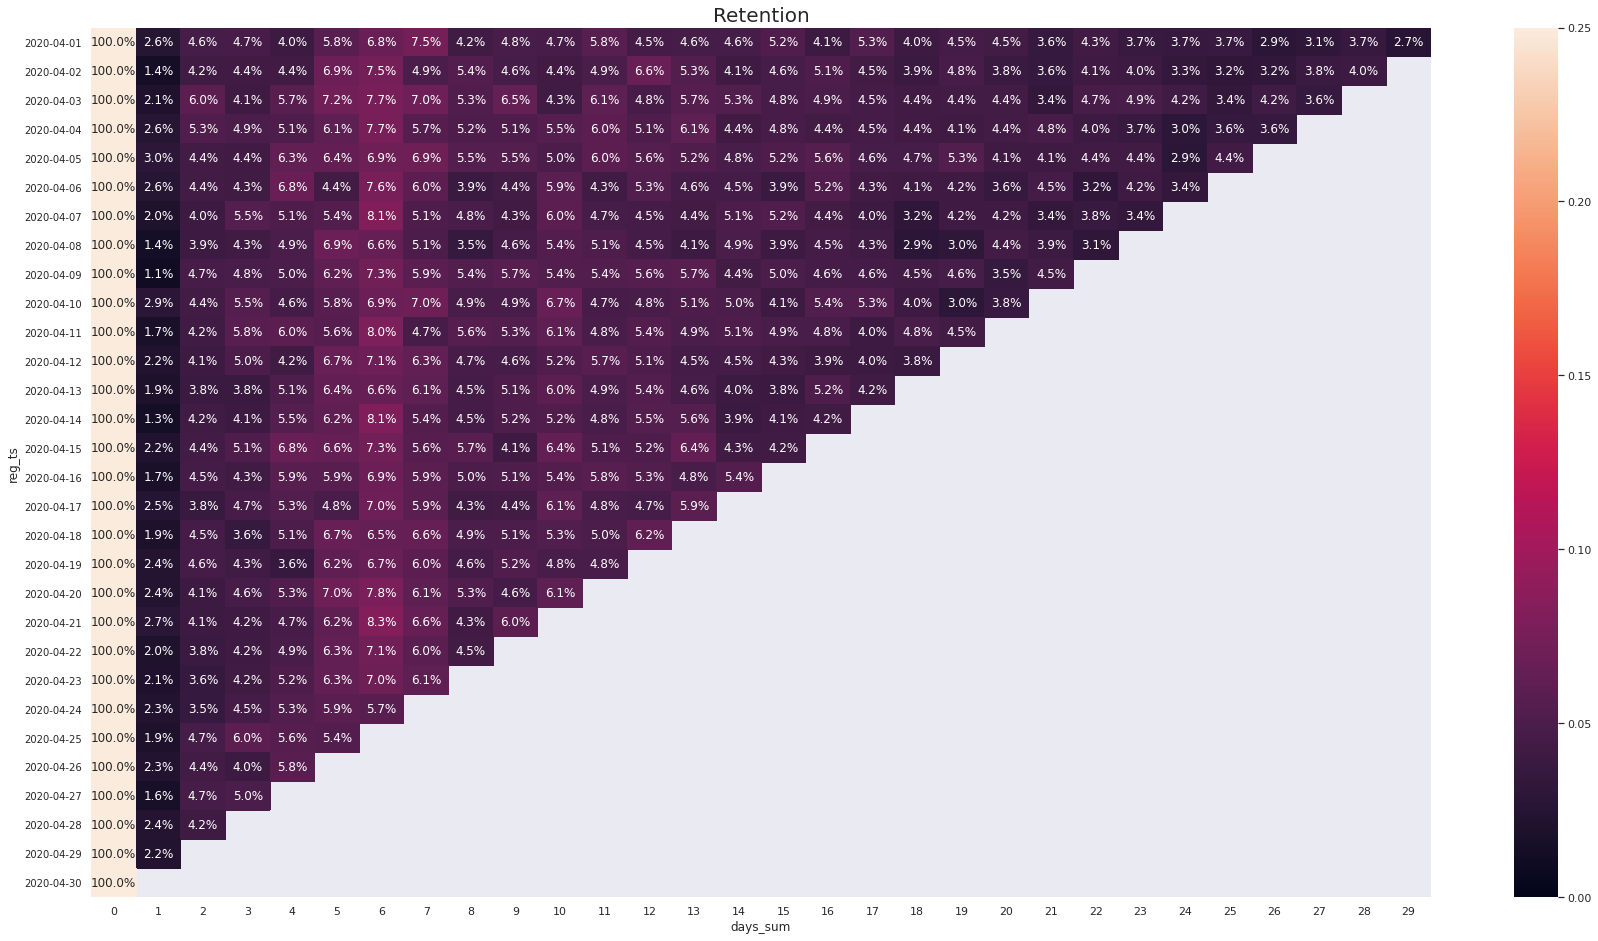

In [26]:
# Сделаю небольшую форму ввода дат начала и окончания расчета для удобства
print('Дата начала расчета retention. Формат даты: "гггг-мм-дд"')
start_d = input()
print('Дата окончания расчета retention. Формат даты: "гггг-мм-дд"')
end_d = input()
retention (reg_data, auth_data, start_d, end_d)

# Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [28]:
import requests
from urllib.parse import urlencode

# Скачиваем файл с яндекс диска:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'

# Получаем загрузочную ссылку
full_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(full_url)
download_url = response.json()['href']

raw_data= pd.read_csv(download_url, delimiter=';')

In [29]:
# Проверка данных
raw_data.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [37]:
raw_data.shape

(404770, 3)

In [34]:
# Основнаяи инфо о датасете
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [39]:
raw_data.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [31]:
raw_data['testgroup'].value_counts()

b    202667
a    202103
Name: testgroup, dtype: int64

- a - контрольная группа

- b - тестовая группа

In [42]:
# Рассчитаем доход от каждой из групп
raw_data.groupby('testgroup', as_index=False) \
    .agg({'revenue':'sum'})

,testgroup,revenue
0,a,5136189
1,b,5421603


In [46]:
# Рассчитаем конверсию в покупку контрольной 
round(1928/202103*100, 2)

0.95

In [48]:
# и тестовой групп
round(1805/202667*100, 2)

0.89

In [51]:
raw_data.query('testgroup == "a"').revenue.describe()

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [52]:
raw_data.query('testgroup == "b"').revenue.describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

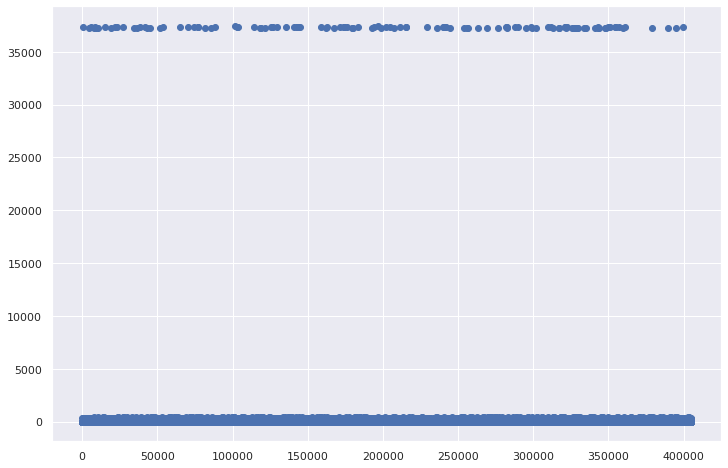

In [54]:
df_a = raw_data.query('testgroup == "a"')
plt.scatter('user_id', 'revenue', data= df_a) 

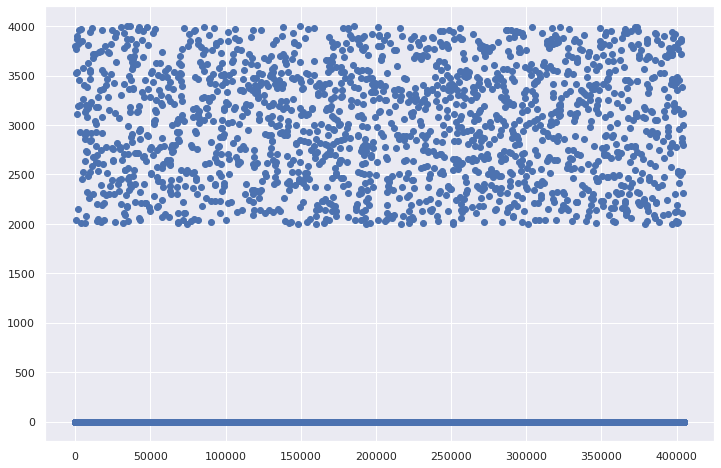

In [56]:
df_b = raw_data.query('testgroup == "b"')
plt.scatter('user_id', 'revenue', data= df_b) 

In [78]:
df_a.query('revenue > 30000').user_id.count()

123

In [79]:
df_b.query('revenue > 2000').user_id.count()

1804

### Промежуточный вывод
Есть заметное различие в числе платящих пользователей между контрольной и тестовой группами. 
При том у тестовой группы конверсия в покупку ниже чем у контрольной, а выручка больше. На диаграмме рассивания видно, что большество покупок в контрольной группе четко превышает 35000 у.е., а в тестовой при этом суммы покупок распределены в большом диапазоне от 2000 до 4000 у.е. 

Это достаточно сильное отличие двух групп, так как в контрольной группе выручка зависит от 123 платящих пользователей, что очень мало и ощутимо скажется при потере каждого. В тестовой группе этот риск влияния меньше, так как выручка распределена между 1805 пользователями и в большем диапазоне значений у.е. каждого платежа.

# A/B

Пусть будут гипотезы:
    
    H0: ARPU выборок в контрольной и тестовой группах не имеют стат. значимых различий;
    H1: ARPU выборок в контрольной и тестовой группах имеют стат. значимые различия.

Порогом принятия альтернативной гипотезы будет альфа 0,05

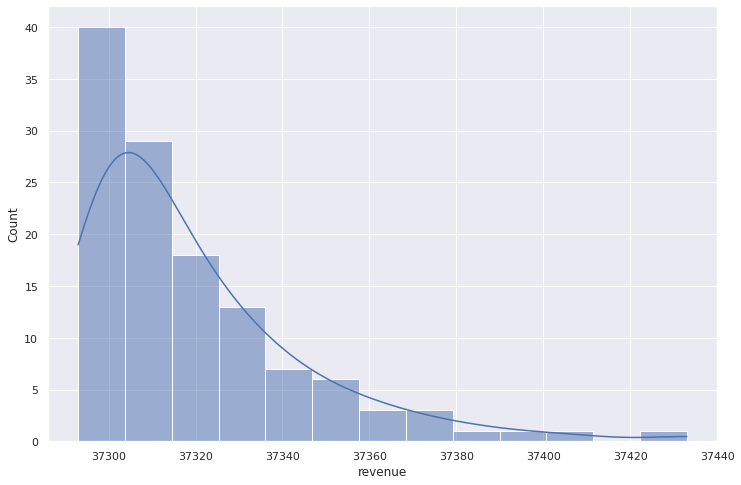

In [83]:
# Посмотрим на распределение выборок c отсеченными нулевыми 
sns.histplot(data=df_a.query('revenue > 35000'), x='revenue', kde=True)

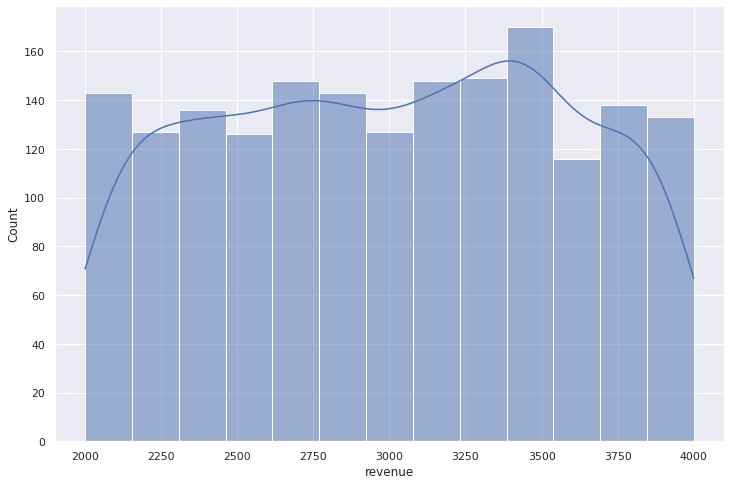

In [90]:
sns.histplot(data=df_b.query('revenue > 2000'), x='revenue', kde=True)

In [97]:
# Применим тест шапиро на проверку нормальности
ss.shapiro(df_a['revenue'].sample(500, random_state=20))

ShapiroResult(statistic=0.03588676452636719, pvalue=3.2229864679470793e-44)

In [96]:
ss.shapiro(df_b['revenue'].sample(500, random_state=20))

ShapiroResult(statistic=0.049545109272003174, pvalue=5.184804318001823e-44)

Распределения не являются нормальными, как и следовало ожидать. Далее для исследования отметаем Т-тест, хотя выборки и достаточно большие, и не будем использовать U-критерий Манна-
Уитни т.к. он проверяет равенство распределений, а не равенство средних.

Нам может помочь бутстрап:

In [98]:
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=2000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

100%|██████████| 2000/2000 [00:45<00:00, 43.56it/s]


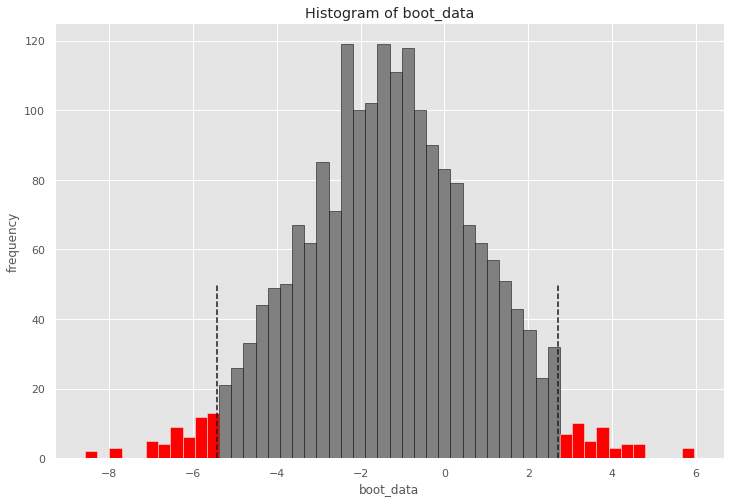

0.5404849970666392

In [107]:
from scipy.stats import norm
booted_show = get_bootstrap(df_a.revenue, df_b.revenue)
booted_show['p_value']

 В результате проверки методом boot_strap p-value > 0.05, что не позволяет нам отклонить нулевую гепотизу, и с уверенностью подтвердить значимые различия в ARPU

Попробуем не отсекать сразу, а сделать более "мягкую фильтрацию"

Сделаем то же самое с ARPPU (и с AOV в данном случае) в тестовой и контрольной группах:

    H0: ARPPU (AOV) не отличаются
    H1: ARPPU (AOV) отличаются

In [117]:
df_a_payed = df_a.query("revenue > 0").revenue
df_b_payed = df_b.query("revenue > 0").revenue

In [119]:
ss.levene(df_a_payed, df_b_payed)

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

Верна гипотеза о там что группы ст. значимо отличаются, так как pvalue < 0.05

100%|██████████| 2000/2000 [00:00<00:00, 2945.07it/s]


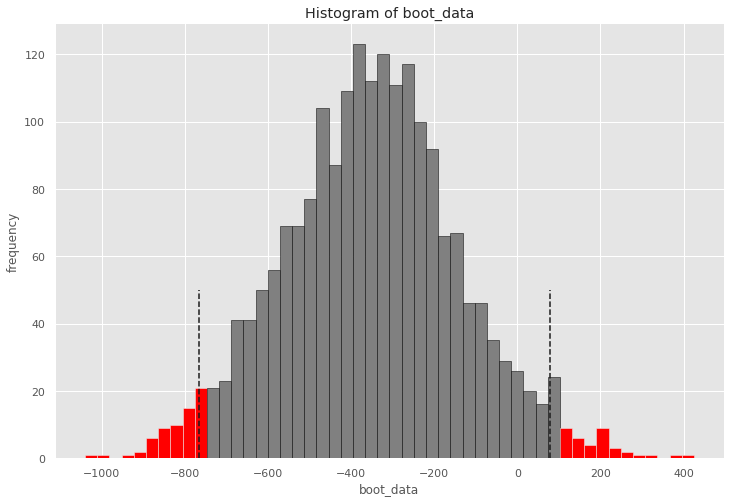

0.09776121537130715

In [120]:
bootstrapped_ab_payed = get_bootstrap(df_a_payed, df_b_payed)
bootstrapped_ab_payed['p_value']

 p-value > 0.05 -> Не отклоняем гипотезу H0, ARPPU (AOV) статзначимо не отличаются.

# Вывод:
Статистически значимых различий двух групп выявить с помощью проводимых А/В тестов не удалось, но это не означает, что их нет. Следует обратить внимание на контрольную группу и систему сбора данных по ней. То, что в "а" группе сумма покупки почти в 12 раз превосходит группу "b", вызывает сомнения в правильности сбора данных. Следует провести А/А тест для проверки работы системы сплитования.

НО! Если сравнивать все две модели, то даже с учетом большей прибыли в группе "а", она является рентабельно неустойчивой, так как зависит от 123 вовлеченных пользователей приносящих 90% прибыли, тогда как в "b" 1805 платящих юзеров и, при снижении их числа, рентабельность компании упадет намного меньше. Поскольку мы не знаем "продукт" и цели бизнеса сложно судить, что является тут приемлемой картиной.

Если учесть, что данные собраны корректно и никаких ошибок в таких больших чеках группы "а" нет, то я бы рекомендовала выкатывать набор акционных предложений B, только для того чтобы не быть зависимыми от такого ограниченного числа юзеров.

# Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события? (1)

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как? (2)

(1) В первую очередь стоит смотреть на конверсию в участие игрока в событии;Стоит отвлеживать метрики DAU,WAU и MAU, в зависимости от длительности ограничений по времени события.В более долгосрочной перспективе стоит разметить активных пользователей в период действия события на участвовавших в нем и нет. Затем в двух когортах провести сравнение retention и ARPU. 
Замер первых двух метрик позволит определить резальтат привлекательности события и его влияние на удержание внимания пользователей. А сравнение retention и ARPU в группах пользователей участвовавших в событии и нет, позволит оценить его влияние на поведение пользователей. 



(2) В данном случае дополнительно понадобится замер retenrion на каждом отдельном уровне. Что бы оценить сложность уровней и посмотреть на каких уровнях большинство игроков оставляет попытки пройти их.Далее понадобится провести исследование CSI после проведения события, и собрать обратную связь от участников. Это позволит оценить насколько данное событие позволило повысить или понизить лояльность игроков.В более долгосрочной перспективе стоит замерить churn rate, retention и ARPU у двух групп активных в период события пользователей, участвовавших и не участвовавших в событии. Это позволит оценить влияние события на пользователей в долгосрочной перспективе. Стало ли больше игроков покидать игру по причине неудовлетворённости новой механикой? Повлияло ли событие на удержание игроков? Повлияло ли событие на увеличение средней выручки с пользователя?